# Capital Allocation Line #

### Building Portfolios Maximizing Sharpe Ratio ###

In [79]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [80]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"Open",
        "High Price":"High",
        "Low Price":"Low",
        "Close Price":"Close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2023-01-01":]

In [81]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

In [82]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['Close']
df_data['AMZN'] = df_2['Close']
df_data['META'] = df_3['Close']
df_data['MSFT'] = df_4['Close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2023-01-03,0.145976,0.190511,0.364881,0.136387
2023-01-04,1.031422,-0.792356,2.108385,-4.374322
2023-01-05,-1.060462,-2.372563,-0.337599,-2.963771
2023-01-06,3.679411,3.561116,2.426343,1.178534
2023-01-09,0.408888,1.486989,-0.423012,0.973636
...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686
2024-10-24,-0.082337,0.904120,0.725576,0.030617


In [83]:
# Create the expected returns and volatilities

expected_returns = df_returns.mean()
volat = df_returns.dropna().std()
cov_matrix = df_returns.dropna().cov()

In [84]:
# Let us obtain the equation again

mu = expected_returns.values.flatten().reshape(-1, 1)
Sigma = cov_matrix.values
Sigma_inv = np.linalg.inv(Sigma)
iota = np.ones((4, 1))

In [85]:
A = np.dot(np.dot(mu.T, Sigma_inv), mu)
B = np.dot(np.dot(iota.T, Sigma_inv), mu)
C = np.dot(np.dot(iota.T, Sigma_inv), iota)
D = (A*C - B*B)

print(f"This is A: {A}")
print(f"This is B: {B}")
print(f"This is C: {C}")
print(f"This is D: {D}")

This is A: [[0.02511156]]
This is B: [[0.0938747]]
This is C: [[0.69251475]]
This is D: [[0.00857766]]


In [86]:
# Then the equation

pi_0 = A/D
pi_1 = 2*B/D
pi_2 = C/D

print(f"This is the first coefficient: {pi_0}")
print(f"This is the second coefficient: {pi_1}")
print(f"This is the third coefficient: {pi_2}")

This is the first coefficient: [[2.92755182]]
This is the second coefficient: [[21.88817348]]
This is the third coefficient: [[80.73465776]]


In [87]:
# Now let us obtain the values of the efficient frontier

def equation(mu_P):
    return np.sqrt((pi_0 - pi_1 * mu_P + pi_2 * mu_P**2))

# Crear un rango de valores para mu_P
mu_P_values = np.linspace(0.09, 0.35, 400)

# Evaluar la ecuación en los valores de mu_P
sigma_P_values = equation(mu_P_values).reshape(-1, 1)

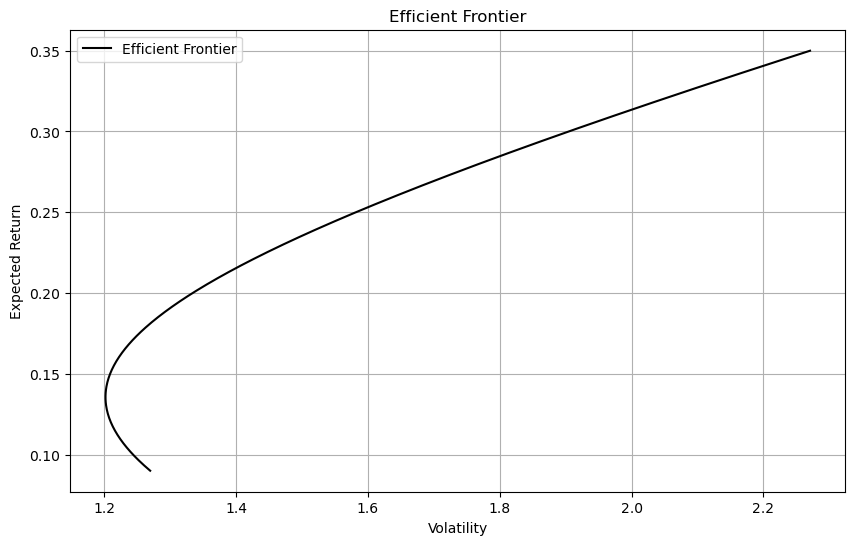

In [88]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Añadir título y etiquetas
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [89]:
# The Most Efficient Portfolio is that which maximizes the Sharp Ratio

rfr = 0.000125

In [90]:
# Tangency Returns

display(Math(r"\mu_T = \frac{2\pi_0 - \pi_1r_f}{\pi_1 - 2\pi_2r_f}"))

<IPython.core.display.Math object>

In [91]:
# Obtain the values

tangency_returns = ((2*pi_0 - pi_1*rfr)/(pi_1 - 2*pi_2*rfr))[0][0]
tangency_volat = equation(tangency_returns)[0][0]

print(f"The Tangency Portfolio Returns are: {tangency_returns}")
print(f"The Tangency Portfolio Volatility is: {tangency_volat}")

The Tangency Portfolio Returns are: 0.2676225688781236
The Tangency Portfolio Volatility is: 1.6888301547225273


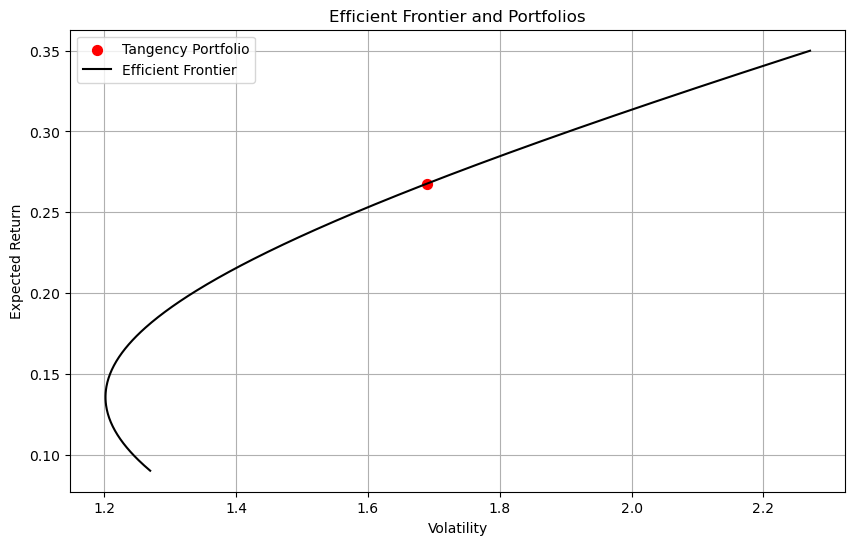

In [92]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')


# Añadir título y etiquetas
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [96]:
# The Maximum Sharpe Ratio is the slope of the capital allocation line

sharpe_ratio = (tangency_returns - rfr)/tangency_volat

print(f"The Maximum Sharpe Ratio is: {sharpe_ratio}")

The Maximum Sharpe Ratio is: 0.15839222679090137


In [98]:
# Define the CAL

def CAL(sigma_P):
    return rfr + sharpe_ratio*sigma_P

# Crear un rango de valores para mu_P
sigma_cal_values = np.linspace(1.1, 2.5, 400)

# Evaluar la ecuación en los valores de mu_P
mu_cal_values = CAL(sigma_cal_values).reshape(-1, 1)

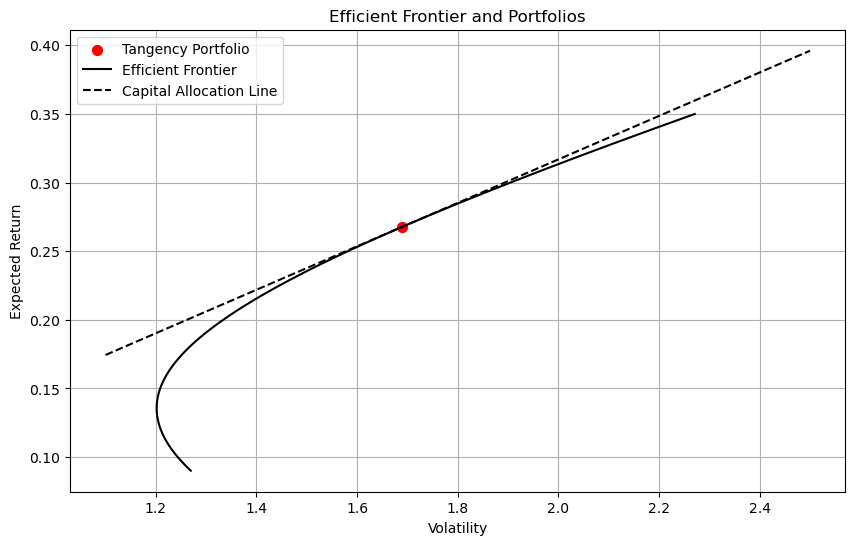

In [100]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')


# Añadir título y etiquetas
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [102]:
# Obtain the Weights of the Tangency Portfolio

def weights(desired_returns):
    D = (A * C) - (B ** 2)

    first_part = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu)
    second_part = ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

    return first_part + second_part 

tangency_weights = weights(tangency_returns)

print(tangency_weights)

[[ 0.46370385]
 [ 0.03589107]
 [ 0.54638813]
 [-0.04598305]]


In [104]:
# Now let us assume we there is an investor willing to take more risk to reach better returns

cal_returns = 0.2

#In a normal case

normal_case_weights = weights(cal_returns)

print(normal_case_weights)

print(f'The sum of weights is: {normal_case_weights.sum().round(2)}')

[[0.49612916]
 [0.05963636]
 [0.24345414]
 [0.20078034]]
The sum of weights is: 1.0


In [106]:
# Define the function to obtain the weights for the CAL

def cal_weights(desired_returns):

    weights = ((desired_returns - rfr) / A) * (Sigma_inv @ mu)

    return weights

cal_weights = cal_weights(cal_returns)

print(cal_weights)

print(f'The sum of weights is: {cal_weights.sum().round(2)}')

if cal_weights.sum().round(2) < 1:
    print('You are a lender')
elif cal_weights.sum().round(2) > 1:
    print('You are a borrower')
else:
    print('You are special')

[[ 0.34652039]
 [ 0.02684955]
 [ 0.40785033]
 [-0.03402621]]
The sum of weights is: 0.75
You are a lender


In [108]:
# Obtain the volatility given the desired returns

def cal_risk(desired_returns):
    return abs(np.sqrt(1/A)*(desired_returns - rfr))

cal_volat = cal_risk(cal_returns)

print(cal_volat)

[[1.26130951]]


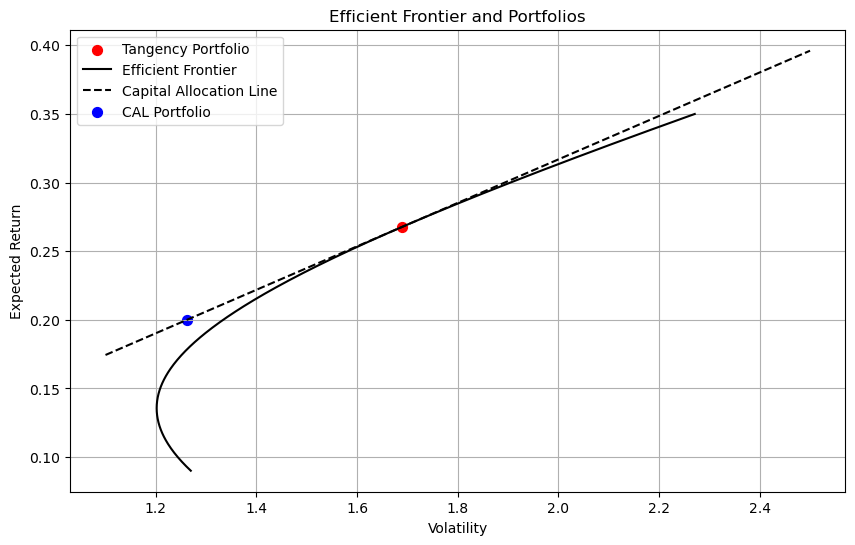

In [110]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(tangency_volat, tangency_returns, color='red', s=50, label='Tangency Portfolio')  
plt.plot(sigma_P_values, mu_P_values, label=r'Efficient Frontier', color='black')
plt.plot(sigma_cal_values, mu_cal_values, label=r'Capital Allocation Line', color='black', linestyle='--')
plt.scatter(cal_volat, cal_returns, color='blue', s=50, label='CAL Portfolio')  


# Añadir título y etiquetas
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [112]:
# Create Portfolios
tangency_portfolio = df_returns[['AAPL', 'AMZN', 'META', 'MSFT']] @ tangency_weights
cal_portfolio = df_returns[['AAPL', 'AMZN', 'META', 'MSFT']] @ cal_weights

# Create DataFrame
df_returns['Tangency Portfolio'] = tangency_portfolio
df_returns['CAL Portfolio'] = cal_portfolio

df_returns

,AAPL,AMZN,META,MSFT,Tangency Portfolio,CAL Portfolio
Date,,,,,,
2023-01-03,0.145976,0.190511,0.364881,0.136387,0.267623,0.199875
2023-01-04,1.031422,-0.792356,2.108385,-4.374322,1.802977,1.344882
2023-01-05,-1.060462,-2.372563,-0.337599,-2.963771,-0.625071,-0.468018
2023-01-06,3.679411,3.561116,2.426343,1.178534,3.105502,2.320089
2023-01-09,0.408888,1.486989,-0.423012,0.973636,-0.032927,-0.024042
...,...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,0.445262,0.332903
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.785650,-2.080542
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.389308,0.290629


In [114]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [116]:
# Now the table
analytics_table = calculate_analytics(df_returns)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,36.786006,21.766463,1.690031,-0.167129,-2.061328
AMZN,48.008774,30.408359,1.578802,-0.196440,-2.631454
META,91.950022,38.963194,2.359920,-0.184264,-2.702421
MSFT,34.369441,22.551066,1.524072,-0.154868,-2.256312
Tangency Portfolio,67.440887,26.809348,2.515574,-0.130769,-2.142378
CAL Portfolio,50.368500,20.022668,2.515574,-0.098267,-1.600165
